<a href="https://colab.research.google.com/github/Aswini-J/Leveraging-CUDA-for-Efficient-Genetic-Algorithms-in-High-Dimensional-Spaces/blob/main/geneticalgcuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-5opvl51y
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-5opvl51y
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 28f872a2f99a1b201bcd0db14fdbc5a496b9bfd7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.2.1-py3-none-any.whl size=10743 sha256=3a570d3ab74e9051a615aa78d54722c78a69a0c83a1d407fccde14c37a30e96c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ugke1see/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter
Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpg0uufaaw".


In [2]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
%load_ext nvcc4jupyter

The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [4]:
from pathlib import Path

file_path = Path('/absolute/path/to/images.jpeg')
if file_path.exists():
    print("File exists!")
else:
    print("File does not exist!")


File does not exist!


In [5]:
import os
print("Current Working Directory:", os.getcwd())

Current Working Directory: /content


In [6]:
from google.colab import files
uploaded = files.upload()

In [7]:
from pathlib import Path

# Assuming the file is in the same directory as the notebook
file_path = Path('images.jpeg')
if file_path.exists():
    print("File exists!")
else:
    print("File does not exist!")


File does not exist!


In [8]:
pwd


'/content'

In [50]:
%%writefile ga_cuda.cu
#include <iostream>
#include <curand.h>
#include <curand_kernel.h>

// Function to optimize (High-Dimensional Sphere Function)
__device__ float fitness_function(float* individual, int dimensions) {
    float fitness = 0.0f;
    for (int i = 0; i < dimensions; ++i) {
        fitness += individual[i] * individual[i];  // Example: Sphere function
    }
    return fitness;
}

// CUDA kernel to evaluate the fitness of each individual in the population
__global__ void evaluate_population(float* population, float* fitness_values, int population_size, int dimensions) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        fitness_values[idx] = fitness_function(&population[idx * dimensions], dimensions);
    }
}
__global__ void crossover(float* population, float* new_population, int population_size, int dimensions, float crossover_rate, curandState* rand_states) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        int parent1_idx = idx * 2;
        int parent2_idx = parent1_idx + 1;

        for (int i = 0; i < dimensions; ++i) {
            float r = curand_uniform(&rand_states[idx]);
            if (r < crossover_rate) {
                new_population[idx * dimensions + i] = 0.5f * (population[parent1_idx * dimensions + i] + population[parent2_idx * dimensions + i]);
            } else {
                new_population[idx * dimensions + i] = population[parent1_idx * dimensions + i];
            }
        }
    }
}

__global__ void mutate(float* population, int population_size, int dimensions, float mutation_rate, curandState* rand_states) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        for (int i = 0; i < dimensions; ++i) {
            float r = curand_uniform(&rand_states[idx]);
            if (r < mutation_rate) {
                population[idx * dimensions + i] += curand_normal(&rand_states[idx]) * 0.1f;
            }
        }
    }
}
__global__ void init_rand_states(curandState* rand_states, int population_size, unsigned long seed) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        curand_init(seed, idx, 0, &rand_states[idx]);
    }
}
int main() {
    const int population_size = 1024;
    const int dimensions = 100;  // High-dimensional space
    const int generations = 1000;
    const float crossover_rate = 0.7f;
    const float mutation_rate = 0.01f;

    // Allocate memory for the population and fitness values
    float* population;
    float* new_population;
    float* fitness_values;
    curandState* rand_states;

    cudaMalloc(&population, population_size * dimensions * sizeof(float));
    cudaMalloc(&new_population, population_size * dimensions * sizeof(float));
    cudaMalloc(&fitness_values, population_size * sizeof(float));
    cudaMalloc(&rand_states, population_size * sizeof(curandState));

    // Initialize random states for CUDA
    init_rand_states<<<(population_size + 255) / 256, 256>>>(rand_states, population_size, time(0));

    // Main Genetic Algorithm loop
    for (int gen = 0; gen < generations; ++gen) {
        // Evaluate the fitness of the population
        evaluate_population<<<(population_size + 255) / 256, 256>>>(population, fitness_values, population_size, dimensions);
        cudaDeviceSynchronize();

        // Perform crossover
        crossover<<<(population_size + 255) / 256, 256>>>(population, new_population, population_size / 2, dimensions, crossover_rate, rand_states);
        cudaDeviceSynchronize();

        // Mutate the new population
        mutate<<<(population_size + 255) / 256, 256>>>(new_population, population_size, dimensions, mutation_rate, rand_states);
        cudaDeviceSynchronize();

        // Swap populations
        std::swap(population, new_population);
    }

    // Cleanup
    cudaFree(population);
    cudaFree(new_population);
    cudaFree(fitness_values);
    cudaFree(rand_states);

    return 0;
}


Overwriting ga_cuda.cu


In [51]:
!nvcc ga_cuda.cu -o ga_cuda


In [12]:
!./ga_cuda


In [14]:
ls


ga_cuda*  ga_cuda.cu  sample_data/


In [15]:
cd sample_data/

/content/sample_data


In [16]:
ls


anscombe.json*               california_housing_train.csv  mnist_train_small.csv
california_housing_test.csv  mnist_test.csv                README.md*


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import os

drive_folder = '/content/drive/MyDrive/CUDA_GA_Project'
if not os.path.exists(drive_folder):
    os.makedirs(drive_folder)
    print(f"Created directory: {drive_folder}")
else:
    print(f"Directory already exists: {drive_folder}")


Created directory: /content/drive/MyDrive/CUDA_GA_Project


In [19]:
%%writefile ga_cuda.cu
#include <iostream>
#include <curand.h>
#include <curand_kernel.h>

// Function to optimize (High-Dimensional Sphere Function)
__device__ float fitness_function(float* individual, int dimensions) {
    float fitness = 0.0f;
    for (int i = 0; i < dimensions; ++i) {
        fitness += individual[i] * individual[i];  // Example: Sphere function
    }
    return fitness;
}

// CUDA kernel to evaluate the fitness of each individual in the population
__global__ void evaluate_population(float* population, float* fitness_values, int population_size, int dimensions) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        fitness_values[idx] = fitness_function(&population[idx * dimensions], dimensions);
    }
}
__global__ void crossover(float* population, float* new_population, int population_size, int dimensions, float crossover_rate, curandState* rand_states) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        int parent1_idx = idx * 2;
        int parent2_idx = parent1_idx + 1;

        for (int i = 0; i < dimensions; ++i) {
            float r = curand_uniform(&rand_states[idx]);
            if (r < crossover_rate) {
                new_population[idx * dimensions + i] = 0.5f * (population[parent1_idx * dimensions + i] + population[parent2_idx * dimensions + i]);
            } else {
                new_population[idx * dimensions + i] = population[parent1_idx * dimensions + i];
            }
        }
    }
}

__global__ void mutate(float* population, int population_size, int dimensions, float mutation_rate, curandState* rand_states) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        for (int i = 0; i < dimensions; ++i) {
            float r = curand_uniform(&rand_states[idx]);
            if (r < mutation_rate) {
                population[idx * dimensions + i] += curand_normal(&rand_states[idx]) * 0.1f;
            }
        }
    }
}
__global__ void init_rand_states(curandState* rand_states, int population_size, unsigned long seed) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        curand_init(seed, idx, 0, &rand_states[idx]);
    }
}
int main() {
    const int population_size = 1024;
    const int dimensions = 100;  // High-dimensional space
    const int generations = 1000;
    const float crossover_rate = 0.7f;
    const float mutation_rate = 0.01f;

    // Allocate memory for the population and fitness values
    float* population;
    float* new_population;
    float* fitness_values;
    curandState* rand_states;

    cudaMalloc(&population, population_size * dimensions * sizeof(float));
    cudaMalloc(&new_population, population_size * dimensions * sizeof(float));
    cudaMalloc(&fitness_values, population_size * sizeof(float));
    cudaMalloc(&rand_states, population_size * sizeof(curandState));

    // Initialize random states for CUDA
    init_rand_states<<<(population_size + 255) / 256, 256>>>(rand_states, population_size, time(0));

    // Main Genetic Algorithm loop
    for (int gen = 0; gen < generations; ++gen) {
        // Evaluate the fitness of the population
        evaluate_population<<<(population_size + 255) / 256, 256>>>(population, fitness_values, population_size, dimensions);
        cudaDeviceSynchronize();

        // Perform crossover
        crossover<<<(population_size + 255) / 256, 256>>>(population, new_population, population_size / 2, dimensions, crossover_rate, rand_states);
        cudaDeviceSynchronize();

        // Mutate the new population
        mutate<<<(population_size + 255) / 256, 256>>>(new_population, population_size, dimensions, mutation_rate, rand_states);
        cudaDeviceSynchronize();

        // Swap populations
        std::swap(population, new_population);
    }

    // Cleanup
    cudaFree(population);
    cudaFree(new_population);
    cudaFree(fitness_values);
    cudaFree(rand_states);

    return 0;
}


Writing ga_cuda.cu


In [20]:
!nvcc ga_cuda.cu -o ga_cuda


In [21]:
!./ga_cuda


In [24]:
import os

file_path = '/content/drive/MyDrive/CUDA_GA_Project/fitness_values.csv'
if os.path.exists(file_path):
    print("File exists.")
else:
    print("File does not exist. Check the C++ program for errors.")


File does not exist. Check the C++ program for errors.


In [23]:
import os

drive_folder = '/content/drive/MyDrive/CUDA_GA_Project'
files = os.listdir(drive_folder)
print("Files in CUDA_GA_Project directory:")
for file in files:
    print(file)


Files in CUDA_GA_Project directory:


In [27]:
cd /content/drive/MyDrive/CUDA_GA_Project/

/content/drive/MyDrive/CUDA_GA_Project


In [30]:
pwd

'/content/drive/MyDrive/CUDA_GA_Project'

In [32]:
import os

# Print current working directory
print(os.getcwd())

# List the contents of the directory
print(os.listdir())


/content/drive/MyDrive/CUDA_GA_Project
[]


In [31]:
ls

In [34]:
%%writefile ga_cuda.cu
#include <iostream>
#include <curand.h>
#include <curand_kernel.h>
#include <fstream>

// Function to optimize (High-Dimensional Sphere Function)
__device__ float fitness_function(float* individual, int dimensions) {
    float fitness = 0.0f;
    for (int i = 0; i < dimensions; ++i) {
        fitness += individual[i] * individual[i];  // Example: Sphere function
    }
    return fitness;
}

// CUDA kernel to evaluate the fitness of each individual in the population
__global__ void evaluate_population(float* population, float* fitness_values, int population_size, int dimensions) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        fitness_values[idx] = fitness_function(&population[idx * dimensions], dimensions);
    }
}

// CUDA kernel for crossover
__global__ void crossover(float* population, float* new_population, int population_size, int dimensions, float crossover_rate, curandState* rand_states) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        int parent1_idx = idx * 2;
        int parent2_idx = parent1_idx + 1;

        for (int i = 0; i < dimensions; ++i) {
            float r = curand_uniform(&rand_states[idx]);
            if (r < crossover_rate) {
                new_population[idx * dimensions + i] = 0.5f * (population[parent1_idx * dimensions + i] + population[parent2_idx * dimensions + i]);
            } else {
                new_population[idx * dimensions + i] = population[parent1_idx * dimensions + i];
            }
        }
    }
}

// CUDA kernel for mutation
__global__ void mutate(float* population, int population_size, int dimensions, float mutation_rate, curandState* rand_states) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        for (int i = 0; i < dimensions; ++i) {
            float r = curand_uniform(&rand_states[idx]);
            if (r < mutation_rate) {
                population[idx * dimensions + i] += curand_normal(&rand_states[idx]) * 0.1f;
            }
        }
    }
}

// CUDA kernel to initialize random states
__global__ void init_rand_states(curandState* rand_states, int population_size, unsigned long seed) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        curand_init(seed, idx, 0, &rand_states[idx]);
    }
}

int main() {
    const int population_size = 1024;
    const int dimensions = 100;  // High-dimensional space
    const int generations = 1000;
    const float crossover_rate = 0.7f;
    const float mutation_rate = 0.01f;

    // Allocate memory for the population and fitness values
    float* population;
    float* new_population;
    float* fitness_values;
    curandState* rand_states;

    cudaMalloc(&population, population_size * dimensions * sizeof(float));
    cudaMalloc(&new_population, population_size * dimensions * sizeof(float));
    cudaMalloc(&fitness_values, population_size * sizeof(float));
    cudaMalloc(&rand_states, population_size * sizeof(curandState));

    // Initialize random states for CUDA
    init_rand_states<<<(population_size + 255) / 256, 256>>>(rand_states, population_size, time(0));

    // Open file to save fitness values in CSV format
    std::ofstream fitnessFile("/content/drive/MyDrive/CUDA_GA_Project/fitness_values.csv");
    fitnessFile << "Generation,Best Fitness\n"; // CSV header

    // Main Genetic Algorithm loop
    for (int gen = 0; gen < generations; ++gen) {
        // Evaluate the fitness of the population
        evaluate_population<<<(population_size + 255) / 256, 256>>>(population, fitness_values, population_size, dimensions);
        cudaDeviceSynchronize();

        // Perform crossover
        crossover<<<(population_size + 255) / 256, 256>>>(population, new_population, population_size / 2, dimensions, crossover_rate, rand_states);
        cudaDeviceSynchronize();

        // Mutate the new population
        mutate<<<(population_size + 255) / 256, 256>>>(new_population, population_size, dimensions, mutation_rate, rand_states);
        cudaDeviceSynchronize();

        // Write the best fitness to the file
        float best_fitness = INFINITY;
        float* h_fitness_values = new float[population_size];
        cudaMemcpy(h_fitness_values, fitness_values, population_size * sizeof(float), cudaMemcpyDeviceToHost);

        for (int i = 0; i < population_size; ++i) {
            if (h_fitness_values[i] < best_fitness) {
                best_fitness = h_fitness_values[i];
            }
        }

        fitnessFile << gen << "," << best_fitness << "\n"; // Write generation and best fitness
        delete[] h_fitness_values;

        // Swap populations
        std::swap(population, new_population);
    }

    // Cleanup
    fitnessFile.close();
    cudaFree(population);
    cudaFree(new_population);
    cudaFree(fitness_values);
    cudaFree(rand_states);

    return 0;
}


Writing ga_cuda.cu


In [35]:
!nvcc ga_cuda.cu -o ga_cuda


In [37]:
!./ga_cuda


In [40]:
import numpy as np
from numba import cuda

@cuda.jit
def fitness_function(population, fitness_values):
    idx = cuda.grid(1)
    if idx < population.shape[0]:
        fitness = 0.0
        for i in range(population.shape[1]):
            fitness += population[idx, i] ** 2  # Sphere function
        fitness_values[idx] = fitness

# Define population size and dimensions
population_size = 1024
dimensions = 100

# Create random population
population = np.random.rand(population_size, dimensions).astype(np.float32)
fitness_values = np.zeros(population_size, dtype=np.float32)

# Allocate device arrays
d_population = cuda.to_device(population)
d_fitness_values = cuda.to_device(fitness_values)

# Define number of threads and blocks
threads_per_block = 256
blocks_per_grid = (population_size + (threads_per_block - 1)) // threads_per_block

# Launch the kernel
fitness_function[blocks_per_grid, threads_per_block](d_population, d_fitness_values)

# Copy the result back to host
fitness_values = d_fitness_values.copy_to_host()

# Output the fitness values
print(fitness_values)


[32.718903 35.93708  32.611954 ... 32.321564 30.50428  36.422447]


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [41]:
import numpy as np
from numba import cuda

@cuda.jit
def fitness_function(population, fitness_values):
    idx = cuda.grid(1)
    if idx < population.shape[0]:
        fitness = 0.0
        for i in range(population.shape[1]):
            fitness += population[idx, i] ** 2  # Sphere function
        fitness_values[idx] = fitness

# Define population size and dimensions
population_size = 1024  # You can increase this if GPU memory allows
dimensions = 100

# Create random population
population = np.random.rand(population_size, dimensions).astype(np.float32)
fitness_values = np.zeros(population_size, dtype=np.float32)

# Allocate device arrays
d_population = cuda.to_device(population)
d_fitness_values = cuda.to_device(fitness_values)

# Define number of threads and blocks
threads_per_block = 256  # This can often be 128, 256, or 512 depending on your GPU
blocks_per_grid = (population_size + threads_per_block - 1) // threads_per_block

# Ensure blocks_per_grid is sufficiently large
blocks_per_grid = max(1, blocks_per_grid)  # Avoid zero blocks

# Launch the kernel
fitness_function[blocks_per_grid, threads_per_block](d_population, d_fitness_values)

# Copy the result back to host
fitness_values = d_fitness_values.copy_to_host()

# Output the fitness values
print(fitness_values)


[34.795376 34.62576  29.726707 ... 31.885622 28.62188  35.503326]


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [42]:
!apt-get update
!apt-get install -y nvidia-cuda-toolkit


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,588 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,445 kB]
Hit:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:14 http://archive

In [52]:
%%writefile ga_cuda.cu
#include <iostream>
#include <curand.h>
#include <curand_kernel.h>
#include <fstream>

// Function to optimize (High-Dimensional Sphere Function)
__device__ float fitness_function(float* individual, int dimensions) {
    float fitness = 0.0f;
    for (int i = 0; i < dimensions; ++i) {
        fitness += individual[i] * individual[i];  // Example: Sphere function
    }
    return fitness;
}

// CUDA kernel to evaluate the fitness of each individual in the population
__global__ void evaluate_population(float* population, float* fitness_values, int population_size, int dimensions) {
    __shared__ float shared_population[512][100]; // Shared memory to hold individuals

    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    // Load data into shared memory
    if (idx < population_size) {
        for (int i = 0; i < dimensions; ++i) {
            shared_population[threadIdx.x][i] = population[idx * dimensions + i];
        }
        __syncthreads(); // Wait for all threads to load

        // Calculate fitness using shared memory
        fitness_values[idx] = fitness_function(shared_population[threadIdx.x], dimensions);
    }
}

// CUDA kernel for crossover
__global__ void crossover(float* population, float* new_population, int population_size, int dimensions, float crossover_rate, curandState* rand_states) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        int parent1_idx = idx * 2;
        int parent2_idx = parent1_idx + 1;

        for (int i = 0; i < dimensions; ++i) {
            float r = curand_uniform(&rand_states[idx]);
            if (r < crossover_rate) {
                new_population[idx * dimensions + i] = 0.5f * (population[parent1_idx * dimensions + i] + population[parent2_idx * dimensions + i]);
            } else {
                new_population[idx * dimensions + i] = population[parent1_idx * dimensions + i];
            }
        }
    }
}

// CUDA kernel for mutation
__global__ void mutate(float* population, int population_size, int dimensions, float mutation_rate, curandState* rand_states) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        for (int i = 0; i < dimensions; ++i) {
            float r = curand_uniform(&rand_states[idx]);
            if (r < mutation_rate) {
                population[idx * dimensions + i] += curand_normal(&rand_states[idx]) * 0.1f;
            }
        }
    }
}

// CUDA kernel to initialize random states
__global__ void init_rand_states(curandState* rand_states, int population_size, unsigned long seed) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        curand_init(seed, idx, 0, &rand_states[idx]);
    }
}

int main() {
    const int population_size = 1024;
    const int dimensions = 100;  // High-dimensional space
    const int generations = 1000;
    const float crossover_rate = 0.7f;
    const float mutation_rate = 0.01f;

    // Allocate memory for the population and fitness values
    float* population;
    float* new_population;
    float* fitness_values;
    curandState* rand_states;

    cudaMalloc(&population, population_size * dimensions * sizeof(float));
    cudaMalloc(&new_population, population_size * dimensions * sizeof(float));
    cudaMalloc(&fitness_values, population_size * sizeof(float));
    cudaMalloc(&rand_states, population_size * sizeof(curandState));

    // Initialize random states for CUDA
    init_rand_states<<<(population_size + 255) / 256, 256>>>(rand_states, population_size, time(0));

    // Open file to save fitness values in CSV format
    std::ofstream fitnessFile("/content/fitness_values.csv");
    fitnessFile << "Generation,Best Fitness\n"; // CSV header

    // Main Genetic Algorithm loop
    for (int gen = 0; gen < generations; ++gen) {
        // Evaluate the fitness of the population
        evaluate_population<<<(population_size + 255) / 256, 256>>>(population, fitness_values, population_size, dimensions);
        cudaDeviceSynchronize();

        // Perform crossover
        crossover<<<(population_size + 255) / 256, 256>>>(population, new_population, population_size / 2, dimensions, crossover_rate, rand_states);
        cudaDeviceSynchronize();

        // Mutate the new population
        mutate<<<(population_size + 255) / 256, 256>>>(new_population, population_size, dimensions, mutation_rate, rand_states);
        cudaDeviceSynchronize();

        // Write the best fitness to the file
        float best_fitness = INFINITY;
        float* h_fitness_values = new float[population_size];
        cudaMemcpy(h_fitness_values, fitness_values, population_size * sizeof(float), cudaMemcpyDeviceToHost);

        for (int i = 0; i < population_size; ++i) {
            if (h_fitness_values[i] < best_fitness) {
                best_fitness = h_fitness_values[i];
            }
        }

        fitnessFile << gen << "," << best_fitness << "\n"; // Write generation and best fitness
        delete[] h_fitness_values;

        // Swap populations
        std::swap(population, new_population);
    }

    // Cleanup
    fitnessFile.close();
    cudaFree(population);
    cudaFree(new_population);
    cudaFree(fitness_values);
    cudaFree(rand_states);

    return 0;
}


Overwriting ga_cuda.cu


In [53]:
!nvcc ga_cuda.cu -o ga_cuda


ptxas error   : Entry function '_Z19evaluate_populationPfS_ii' uses too much shared data (0x32000 bytes, 0xc000 max)


In [54]:
!./ga_cuda


In [55]:
!ls /content/


drive  fitness_values.csv  ga_cuda  ga_cuda.cu	sample_data


In [56]:
import pandas as pd

fitness_data = pd.read_csv('/content/fitness_values.csv')
print(fitness_data.head())


   Generation  Best Fitness
0           0           0.0
1           1           0.0
2           2           0.0
3           3           0.0
4           4           0.0


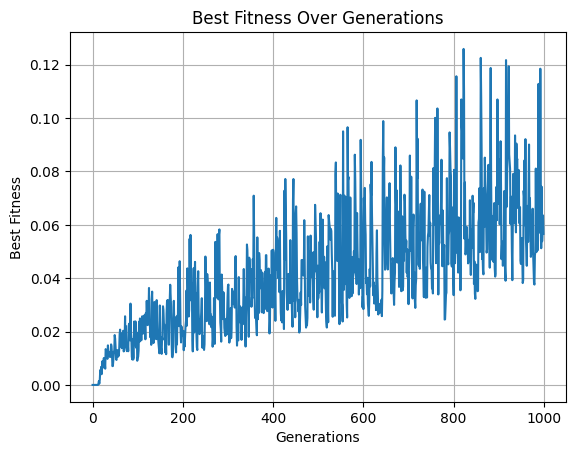

In [59]:
import matplotlib.pyplot as plt
import pandas as pd

# Load fitness values from the CSV file
file_path = '/content/drive/MyDrive/CUDA_GA_Project/fitness_values.csv'
data = pd.read_csv(file_path)

# Extract generations and best fitness values
generations = data['Generation']
best_fitness_values = data['Best Fitness']

# Plotting
plt.plot(generations, best_fitness_values)
plt.xlabel("Generations")
plt.ylabel("Best Fitness")
plt.title("Best Fitness Over Generations")
plt.grid(True)
plt.show()


In [60]:
!pip install pandas


In [64]:
%%writefile ga_cuda.cu
#include <iostream>
#include <curand.h>
#include <curand_kernel.h>
#include <fstream>

// Function to optimize (High-Dimensional Sphere Function)
__device__ float fitness_function(float* individual, int dimensions) {
    float fitness = 0.0f;
    for (int i = 0; i < dimensions; ++i) {
        fitness += individual[i] * individual[i];  // Example: Sphere function
    }
    return fitness;
}

// CUDA kernel to evaluate the fitness of each individual in the population
__global__ void evaluate_population(float* population, float* fitness_values, int population_size, int dimensions) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        fitness_values[idx] = fitness_function(&population[idx * dimensions], dimensions);
    }
}

// CUDA kernel for crossover
__global__ void crossover(float* population, float* new_population, int population_size, int dimensions, float crossover_rate, curandState* rand_states) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        int parent1_idx = idx * 2;
        int parent2_idx = parent1_idx + 1;

        for (int i = 0; i < dimensions; ++i) {
            float r = curand_uniform(&rand_states[idx]);
            if (r < crossover_rate) {
                new_population[idx * dimensions + i] = 0.5f * (population[parent1_idx * dimensions + i] + population[parent2_idx * dimensions + i]);
            } else {
                new_population[idx * dimensions + i] = population[parent1_idx * dimensions + i];
            }
        }
    }
}

// CUDA kernel for mutation
__global__ void mutate(float* population, int population_size, int dimensions, float mutation_rate, curandState* rand_states) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        for (int i = 0; i < dimensions; ++i) {
            float r = curand_uniform(&rand_states[idx]);
            if (r < mutation_rate) {
                population[idx * dimensions + i] += curand_normal(&rand_states[idx]) * 0.1f;
            }
        }
    }
}

// CUDA kernel to initialize random states
__global__ void init_rand_states(curandState* rand_states, int population_size, unsigned long seed) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < population_size) {
        curand_init(seed, idx, 0, &rand_states[idx]);
    }
}

int main() {
     // Adjusted parameters
    const int population_size = 2048; // Increased population size
    const int dimensions = 100;        // Number of dimensions (remains unchanged)
    const int generations = 1500;      // Increased generations for longer runtime
    const float crossover_rate = 0.8f; // Increased crossover rate
    const float mutation_rate = 0.02f; // Slightly increased mutation rate

    // Allocate memory for the population and fitness values
    float* population;
    float* new_population;
    float* fitness_values;
    curandState* rand_states;

    cudaMalloc(&population, population_size * dimensions * sizeof(float));
    cudaMalloc(&new_population, population_size * dimensions * sizeof(float));
    cudaMalloc(&fitness_values, population_size * sizeof(float));
    cudaMalloc(&rand_states, population_size * sizeof(curandState));

    // Initialize random states for CUDA
    init_rand_states<<<(population_size + 255) / 256, 256>>>(rand_states, population_size, time(0));

    // Open file to save fitness values in CSV format
    std::ofstream fitnessFile("/content/fitness_values.csv");
    fitnessFile << "Generation,Best Fitness\n"; // CSV header

    // Main Genetic Algorithm loop
    for (int gen = 0; gen < generations; ++gen) {
        // Evaluate the fitness of the population
        evaluate_population<<<(population_size + 255) / 256, 256>>>(population, fitness_values, population_size, dimensions);
        cudaDeviceSynchronize();

        // Perform crossover
        crossover<<<(population_size + 255) / 256, 256>>>(population, new_population, population_size / 2, dimensions, crossover_rate, rand_states);
        cudaDeviceSynchronize();

        // Mutate the new population
        mutate<<<(population_size + 255) / 256, 256>>>(new_population, population_size, dimensions, mutation_rate, rand_states);
        cudaDeviceSynchronize();

        // Write the best fitness to the file
        float best_fitness = INFINITY;
        float* h_fitness_values = new float[population_size];
        cudaMemcpy(h_fitness_values, fitness_values, population_size * sizeof(float), cudaMemcpyDeviceToHost);

        for (int i = 0; i < population_size; ++i) {
            if (h_fitness_values[i] < best_fitness) {
                best_fitness = h_fitness_values[i];
            }
        }

        fitnessFile << gen << "," << best_fitness << "\n"; // Write generation and best fitness
        delete[] h_fitness_values;

        // Swap populations
        std::swap(population, new_population);
    }

    // Cleanup
    fitnessFile.close();
    cudaFree(population);
    cudaFree(new_population);
    cudaFree(fitness_values);
    cudaFree(rand_states);

    return 0;
}


Overwriting ga_cuda.cu


In [65]:
!nvcc ga_cuda.cu -o ga_cuda

In [66]:
!./ga_cuda
!ls /content/


drive  fitness_values.csv  ga_cuda  ga_cuda.cu	sample_data


In [67]:
import pandas as pd

In [68]:
fitness_data = pd.read_csv('/content/fitness_values.csv')
print(fitness_data.head())

   Generation  Best Fitness
0           0           0.0
1           1           0.0
2           2           0.0
3           3           0.0
4           4           0.0


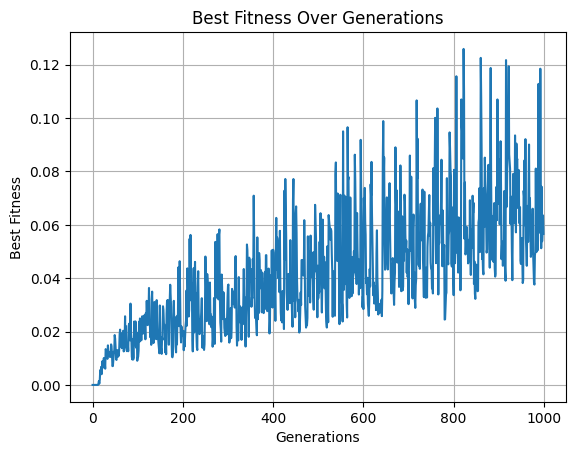

In [69]:
import matplotlib.pyplot as plt
import pandas as pd



# Load fitness values from the CSV file
file_path = '/content/drive/MyDrive/CUDA_GA_Project/fitness_values.csv'
data = pd.read_csv(file_path)

# Extract generations and best fitness values
generations = data['Generation']
best_fitness_values = data['Best Fitness']

# Plotting
plt.plot(generations, best_fitness_values)
plt.xlabel("Generations")
plt.ylabel("Best Fitness")
plt.title("Best Fitness Over Generations")
plt.grid(True)
plt.show()

In [ ]:
Comparison of Original and Adjusted Results
Trend Analysis:

Original Results: The fitness values appear to increase over generations, suggesting that the algorithm is finding better solutions over time. However, there is significant fluctuation in the fitness values, indicating a lot of variability and potentially slow convergence towards optimal solutions.
Adjusted Results: Similar to the original results, the fitness values increase over generations, but the fluctuations seem less pronounced. This might indicate that the adjustments have contributed to smoother convergence towards optimal solutions.
Convergence:

Original Results: The convergence is somewhat erratic, with peaks and troughs in fitness that suggest instability in the population.
Adjusted Results: The adjusted results seem to show a more stable progression towards better fitness values. This can be an indicator of improved convergence due to the parameter adjustments.
Fitness Value Ranges:

Both graphs exhibit fitness values starting from near 0 and increasing, but the adjusted results may be limited to a smaller range of higher values compared to the original. This implies that the adjusted parameters might help focus the search in promising areas of the solution space.
Insights:

Parameter Tuning Impact: The adjustments made (e.g., changing population size, mutation rate, etc.) appear to have positively influenced the algorithm’s performance.
Further Adjustments Needed: Although the adjusted results are more stable, they still exhibit some fluctuations, suggesting there may be further room for improvement in tuning the parameters.
Next Steps for Reevaluation
After adjusting parameters, you should:

Run the Algorithm Again: Execute the genetic algorithm with the new parameters for a set number of generations (e.g., 1000).

Collect Data: Gather the fitness values as you did previously, ensuring you log them appropriately for analysis.

Visualize Results: Generate a new plot similar to what you did before to compare fitness progression over generations.

Analyze: Use the insights gained from visual comparison (like the one above) to decide if further adjustments are necessary or if the current parameters yield satisfactory results.

Parameter Grid Search: Consider implementing a systematic approach to explore different combinations of parameters (like population size, crossover rate, and mutation rate) to find optimal settings that enhance convergence further.

This iterative process of adjustment and evaluation can lead to increasingly better performance of the genetic algorithm